In [38]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import shap
df = pd.read_csv("Airline_Delay_Cause.csv")
df = df[df['arr_flights'].notna() & (df['arr_flights'] != 0)]
df['arr_del15'] = df['arr_del15'].fillna(0)
df['is_peak_summer'] = df['month'].isin([6, 7]).astype(int)
df['is_holiday_season'] = (df['month'] == 12).astype(int)
df['is_low_risk_fall'] = df['month'].isin([9, 10]).astype(int)
df.drop(['carrier_name'],axis = 1,inplace = True)
df['dominant_delay_cause'] = df[['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']].idxmax(axis=1)

carrier_counts = df['carrier'].value_counts()
quantiles = carrier_counts.quantile([0.33, 0.66])
def volume_tier(carrier):
    count = carrier_counts[carrier]
    if count <= quantiles[0.33]:
        return 'low'
    elif count <= quantiles[0.66]:
        return 'medium'
    else:
        return 'high'
df['flight_volume_tier'] = df['carrier'].apply(volume_tier)
df = df.drop(columns=['airport_name'])
airport_avg_delay = df.groupby('airport')['arr_delay'].mean().sort_values(ascending=False)
airport_delay_dict = airport_avg_delay.to_dict()
# STEP 0: Sanity check the delay dictionary
if not isinstance(airport_delay_dict, dict) or not airport_delay_dict:
    raise ValueError("airport_delay_dict must be a non-empty dictionary")
airport_delay_df = pd.DataFrame(
    list(airport_delay_dict.items()),
    columns=['airport', 'airport_avg_delay']
)
df = df.merge(airport_delay_df, on='airport', how='left')

def classify_delay_severity(delay):
    if delay >= 20000:
        return 'Severe'
    elif delay >= 10000:
        return 'Moderate'
    elif delay >= 3000:
        return 'Mild'
    else:
        return 'Low'

df['delay_severity_class_of_airport'] = df['airport_avg_delay'].apply(classify_delay_severity)

top20_volume_airports = (
    df.groupby('airport')['arr_flights']
      .sum()
      .sort_values(ascending=False)
      .head(20)
      .index
)
df['is_high_volume_airport'] = df['airport'].isin(top20_volume_airports).astype(int)

airport_flight_volume = (
    df.groupby('airport')['arr_flights']
      .sum()
      .reset_index()
      .rename(columns={'arr_flights': 'total_flights'})
)
df = df.merge(airport_flight_volume, on='airport', how='left')

low_delay_airports = (
    airport_delay_df
    .sort_values(by='airport_avg_delay')
    .head(20)['airport']
)
df['is_low_delay_airport'] = df['airport'].isin(low_delay_airports).astype(int)



In [39]:
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)

df['year_month'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

df = df.sort_values('year_month')
unique_months = df['year_month'].sort_values().drop_duplicates().reset_index(drop=True)

month_to_idx = {month: idx+1 for idx, month in enumerate(unique_months)}

df['time_idx'] = df['year_month'].map(month_to_idx)
df.drop(['year_month'], axis = 1, inplace = True)
df['delay_rate'] = df['arr_del15']/df['arr_flights']
df['controlable_ratio'] = (df['carrier_delay']+df['late_aircraft_delay'])/(df['arr_delay'])
df['avg_delay_per_flights'] = df['arr_delay']/df['arr_flights']
df['contr_delay_per_flight'] =  (df['late_aircraft_delay']+df['carrier_delay'])/df['arr_flights']

In [40]:
df.columns

Index(['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15',
       'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'is_peak_summer', 'is_holiday_season', 'is_low_risk_fall',
       'dominant_delay_cause', 'flight_volume_tier', 'airport_avg_delay',
       'delay_severity_class_of_airport', 'is_high_volume_airport',
       'total_flights', 'is_low_delay_airport', 'time_idx', 'delay_rate',
       'controlable_ratio', 'avg_delay_per_flights', 'contr_delay_per_flight'],
      dtype='object')

In [41]:
df2 = df.copy()
df.isnull().sum()

year                                  0
month                                 0
carrier                               0
airport                               0
arr_flights                           0
arr_del15                             0
carrier_ct                            0
weather_ct                            0
nas_ct                                0
security_ct                           0
late_aircraft_ct                      0
arr_cancelled                         0
arr_diverted                          0
arr_delay                             0
carrier_delay                         0
weather_delay                         0
nas_delay                             0
security_delay                        0
late_aircraft_delay                   0
is_peak_summer                        0
is_holiday_season                     0
is_low_risk_fall                      0
dominant_delay_cause                  0
flight_volume_tier                    0
airport_avg_delay                     0


In [42]:
df2["target"] = (df2["delay_rate"] > 0.25).astype(int)
df2["controlable_ratio"] = df2["controlable_ratio"].fillna(0)
df2["sample_weight"] = df2["controlable_ratio"]+1
df2["year_month"] = pd.to_datetime(df2[["year", "month"]].assign(day=1))
df2 = df2.sort_values(["carrier", "airport", "year_month"])
group = df2.groupby(["carrier", "airport"])
df2["arr_del15_rolling3"] = group["arr_del15"].transform(lambda x: x.shift(1).rolling(3).mean())
df2["delay_rate_rolling3"] = group["delay_rate"].transform(lambda x: x.shift(1).rolling(3).mean())
df2["arr_flights_rolling3"] = group["arr_flights"].transform(lambda x: x.shift(1).rolling(3).mean())

for col in ["arr_del15", "delay_rate", "arr_flights"]:
    df2[f"{col}_lag1"] = group[col].shift(1)
    df2[f"{col}_lag3"] = group[col].shift(3)
    df2[f"{col}_lag12"] = group[col].shift(12)

df2["sin_month"] = np.sin(2 * np.pi * df2["month"] / 12)
df2["cos_month"] = np.cos(2 * np.pi * df2["month"] / 12)

df2 = df2.dropna(subset=[
    "arr_del15_rolling3", "delay_rate_rolling3", "arr_flights_rolling3",
    "arr_del15_lag1", "delay_rate_lag1", "arr_flights_lag1"
])

features = [
    "arr_del15_rolling3", "delay_rate_rolling3", "arr_flights_rolling3",
    "arr_del15_lag1", "delay_rate_lag1", "arr_flights_lag1",
    "sin_month", "cos_month"
]
group = df2.groupby(["carrier", "airport"])

df2["controllable_delay"] = df2["carrier_delay"] + df2["late_aircraft_delay"]
df2["uncontrollable_delay"] = df2["weather_delay"] + df2["nas_delay"] + df2["security_delay"]

for col in ["controllable_delay", "uncontrollable_delay", "arr_delay"]:
    df2[f"{col}_lag1"] = group[col].shift(1)
    df2[f"{col}_lag3"] = group[col].shift(3)
    df2[f"{col}_lag12"] = group[col].shift(12)
    df2[f"{col}_rolling3"] = group[col].shift(1).rolling(3).mean()

df2["quarter"] = ((df2["month"] - 1) // 3 + 1).astype(int)

g = df2.groupby(["carrier", "airport"])

for col in ["controllable_delay","uncontrollable_delay","arr_delay"]:
    df2[f"{col}_ewm3"] = (
        g[col]
        .apply(lambda x: x.shift(1).ewm(span=3, adjust=False).mean())
        .reset_index(level=[0,1], drop=True)
    )
def slope(series):
   
    y = series.values
    x = np.arange(len(y))
    if np.isnan(y).all(): return np.nan
    return np.polyfit(x, y, 1)[0]

for col in ["controllable_delay","uncontrollable_delay","arr_delay"]:
    df2[f"{col}_slope3"] = (
        g[col]
        .apply(lambda x: x.shift(1).rolling(3).apply(slope, raw=False))
        .reset_index(level=[0,1], drop=True)
    )
df2.drop(['year','arr_del15','carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
       'arr_cancelled', 'arr_diverted', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay','dominant_delay_cause','total_flights','delay_rate','controlable_ratio','year_month',
        'arr_flights_lag1','arr_flights_lag3', 'arr_flights_lag12','arr_flights_rolling3'],axis = 1, inplace = True)
df2.drop(['controllable_delay_ewm3',
       'uncontrollable_delay_ewm3', 'arr_delay_ewm3',
       'controllable_delay_slope3', 'uncontrollable_delay_slope3',
       'arr_delay_slope3'],axis = 1, inplace = True)

In [43]:
df2 =  df2.dropna()
X = df2.copy()
y = X['target']
avg_delay_per_flights = X['avg_delay_per_flights']
contr_delay_per_flight = X['contr_delay_per_flight']
X.drop(['contr_delay_per_flight', 'avg_delay_per_flights','arr_delay', 'controllable_delay', 'arr_flights','uncontrollable_delay'],axis = 1, inplace = True)
X.drop(['target'],axis = 1, inplace=True)
sample_weight = X['sample_weight']
X.drop(['sample_weight'],axis = 1, inplace = True)
X =  X.dropna()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135507 entries, 103073 to 24456
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   month                            135507 non-null  int32  
 1   carrier                          135507 non-null  object 
 2   airport                          135507 non-null  object 
 3   is_peak_summer                   135507 non-null  int32  
 4   is_holiday_season                135507 non-null  int32  
 5   is_low_risk_fall                 135507 non-null  int32  
 6   flight_volume_tier               135507 non-null  object 
 7   airport_avg_delay                135507 non-null  float64
 8   delay_severity_class_of_airport  135507 non-null  object 
 9   is_high_volume_airport           135507 non-null  int32  
 10  is_low_delay_airport             135507 non-null  int32  
 11  time_idx                         135507 non-null  int64  
 12  arr

In [44]:
binary_cols = [
    "is_peak_summer", "is_holiday_season", "is_low_risk_fall",
    "is_high_volume_airport", "is_low_delay_airport"
]
categorical_cols = [
    "carrier", "airport", "flight_volume_tier", "delay_severity_class_of_airport"
]
X[binary_cols] = X[binary_cols].astype(bool)
X[categorical_cols] = X[categorical_cols].astype("category")
X["month"] = X["month"].astype("category")
X["quarter"] = X["quarter"].astype("category")



In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135507 entries, 103073 to 24456
Data columns (total 35 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   month                            135507 non-null  category
 1   carrier                          135507 non-null  category
 2   airport                          135507 non-null  category
 3   is_peak_summer                   135507 non-null  bool    
 4   is_holiday_season                135507 non-null  bool    
 5   is_low_risk_fall                 135507 non-null  bool    
 6   flight_volume_tier               135507 non-null  category
 7   airport_avg_delay                135507 non-null  float64 
 8   delay_severity_class_of_airport  135507 non-null  category
 9   is_high_volume_airport           135507 non-null  bool    
 10  is_low_delay_airport             135507 non-null  bool    
 11  time_idx                         135507 non-null  int

In [46]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weight,
    test_size=0.2,
    stratify=y,
    random_state=42
)
dtrain = xgb.DMatrix(X_train, label=y_train, weight=w_train, enable_categorical=True)
dtest  = xgb.DMatrix(X_test,  label=y_test,  weight=w_test,  enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtest, "eval")],
    early_stopping_rounds=50,
    verbose_eval=10
)

y_pred  = (model.predict(dtest) > 0.5).astype(int)
y_score = model.predict(dtest)

print("Classification Report:")
print(classification_report(y_test, y_pred, sample_weight=w_test))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred, sample_weight=w_test))

print(f"AUC (weighted): {roc_auc_score(y_test, y_score, sample_weight=w_test):.4f}")


[0]	eval-auc:0.82111
[10]	eval-auc:0.85288
[20]	eval-auc:0.85406
[30]	eval-auc:0.85597
[40]	eval-auc:0.85913
[50]	eval-auc:0.86129
[60]	eval-auc:0.86512
[70]	eval-auc:0.86725
[80]	eval-auc:0.86913
[90]	eval-auc:0.87122
[100]	eval-auc:0.87229
[110]	eval-auc:0.87347
[120]	eval-auc:0.87388
[130]	eval-auc:0.87457
[140]	eval-auc:0.87519
[150]	eval-auc:0.87579
[160]	eval-auc:0.87599
[170]	eval-auc:0.87716
[180]	eval-auc:0.87771
[190]	eval-auc:0.87808
[200]	eval-auc:0.87838
[210]	eval-auc:0.87891
[220]	eval-auc:0.87955
[230]	eval-auc:0.87974
[240]	eval-auc:0.88049
[250]	eval-auc:0.88079
[260]	eval-auc:0.88129
[270]	eval-auc:0.88149
[280]	eval-auc:0.88151
[290]	eval-auc:0.88213
[300]	eval-auc:0.88294
[310]	eval-auc:0.88316
[320]	eval-auc:0.88341
[330]	eval-auc:0.88343
[340]	eval-auc:0.88345
[350]	eval-auc:0.88355
[360]	eval-auc:0.88347
[370]	eval-auc:0.88385
[380]	eval-auc:0.88384
[390]	eval-auc:0.88381
[400]	eval-auc:0.88387
[410]	eval-auc:0.88389
[420]	eval-auc:0.88388
[430]	eval-auc:0.88409


🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91 36667.06661243374
           1       0.68      0.56      0.62 9583.303784136375

    accuracy                           0.85 46250.37039657011
   macro avg       0.79      0.75      0.76 46250.37039657011
weighted avg       0.85      0.85      0.85 46250.37039657011


✅ Evaluation Metrics (Weighted):
Accuracy:  0.8545
Precision: 0.6791
Recall:    0.5642
F1 Score:  0.6164
AUC-ROC:   0.8864

🧮 Confusion Matrix (Weighted):
[[34112.31702669  2554.74958574]
 [ 4176.03018818  5407.27359595]]


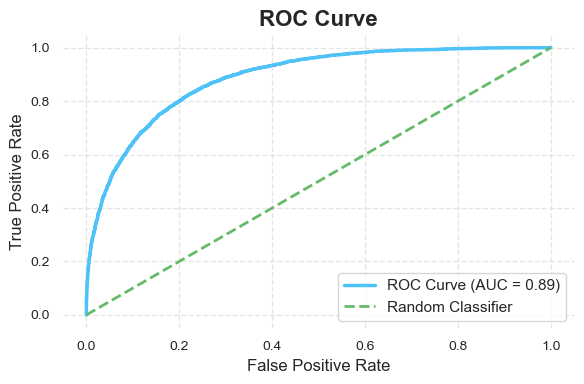

In [47]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
y_proba = model.predict(dtest)
y_pred  = (y_proba > 0.45).astype(int)

accuracy  = accuracy_score(y_test, y_pred, sample_weight=w_test)
precision = precision_score(y_test, y_pred, sample_weight=w_test)
recall    = recall_score(y_test, y_pred, sample_weight=w_test)
f1        = f1_score(y_test, y_pred, sample_weight=w_test)
auc       = roc_auc_score(y_test, y_proba, sample_weight=w_test)
conf_mat  = confusion_matrix(y_test, y_pred, sample_weight=w_test)

print("\n🔍 Classification Report:")
print(classification_report(y_test, y_pred, sample_weight=w_test))

print(f"\n✅ Evaluation Metrics (Weighted):")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")

print("\n🧮 Confusion Matrix (Weighted):")
print(conf_mat)

fpr, tpr, _ = roc_curve(y_test, y_proba, sample_weight=w_test)

plt.figure(figsize=(6, 4))
sns.set(style='whitegrid')

plt.plot(fpr, tpr, color='#4fc3f7', linewidth=2.5, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='#66bb6a', linestyle='--', linewidth=2, label='Random Classifier')

plt.title('ROC Curve', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.box(False)
plt.show()


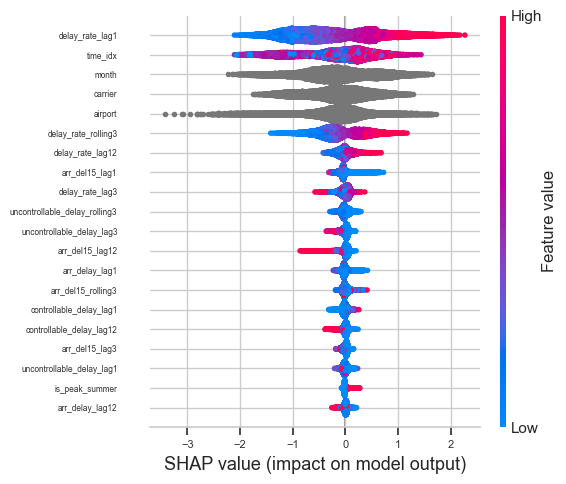

In [48]:
explainer   = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest)

plt.figure(figsize=(4, 3))

shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns,
    show=False,
    plot_size = (6,5)
)

ax = plt.gca()
ax.tick_params(axis='y', labelsize=6)  
ax.tick_params(axis='x', labelsize=8)   

plt.tight_layout()
plt.show()


In [49]:
X2 = X.copy()
X2.drop(['is_peak_summer', 'is_holiday_season',
       'is_low_risk_fall', 'flight_volume_tier',
       'delay_severity_class_of_airport', 'is_high_volume_airport',
       'is_low_delay_airport'],axis = 1, inplace = True)
X2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135507 entries, 103073 to 24456
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   month                          135507 non-null  category
 1   carrier                        135507 non-null  category
 2   airport                        135507 non-null  category
 3   airport_avg_delay              135507 non-null  float64 
 4   time_idx                       135507 non-null  int64   
 5   arr_del15_rolling3             135507 non-null  float64 
 6   delay_rate_rolling3            135507 non-null  float64 
 7   arr_del15_lag1                 135507 non-null  float64 
 8   arr_del15_lag3                 135507 non-null  float64 
 9   arr_del15_lag12                135507 non-null  float64 
 10  delay_rate_lag1                135507 non-null  float64 
 11  delay_rate_lag3                135507 non-null  float64 
 12  delay_rate_lag12 

In [50]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score
)

mask = (y == 1)
X_filtered = X2[mask]
y_filtered = avg_delay_per_flights[mask]
w_filtered = sample_weight[mask]

pct = 99
threshold = np.percentile(y_filtered, pct)
print(f"Trimming delays > {pct}th percentile = {threshold:.1f} minutes")

keep = (y_filtered <= threshold)
X_trim = X_filtered[keep]
y_trim = y_filtered[keep]
w_trim = w_filtered[keep]


X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_trim, y_trim, w_trim,
    test_size=0.2,
    random_state=42
)


dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest  = xgb.DMatrix(X_test,  label=y_test, enable_categorical=True)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "seed": 42
}

reg = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=[(dtest, "eval")],
    early_stopping_rounds=30,
    verbose_eval=10
)

y_pred = reg.predict(dtest)

print("\n📈 Regression Evaluation (trimmed at 99th percentile):")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE : {root_mean_squared_error(y_test, y_pred):.4f}")


Trimming delays > 99th percentile = 74.0 minutes
[0]	eval-rmse:9.72095
[10]	eval-rmse:9.25753
[20]	eval-rmse:9.01407
[30]	eval-rmse:8.88097
[40]	eval-rmse:8.79342
[50]	eval-rmse:8.75943
[60]	eval-rmse:8.72968
[70]	eval-rmse:8.69407
[80]	eval-rmse:8.68199
[90]	eval-rmse:8.67036
[100]	eval-rmse:8.67181
[110]	eval-rmse:8.66483
[120]	eval-rmse:8.67071
[130]	eval-rmse:8.67636
[136]	eval-rmse:8.67794

📈 Regression Evaluation (trimmed at 99th percentile):
MAE  : 6.1242
MSE  : 75.3309
RMSE : 8.6793


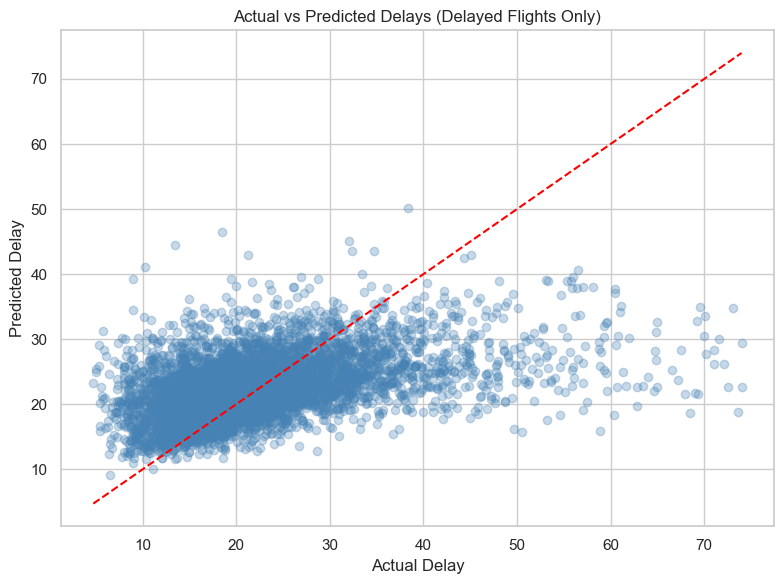

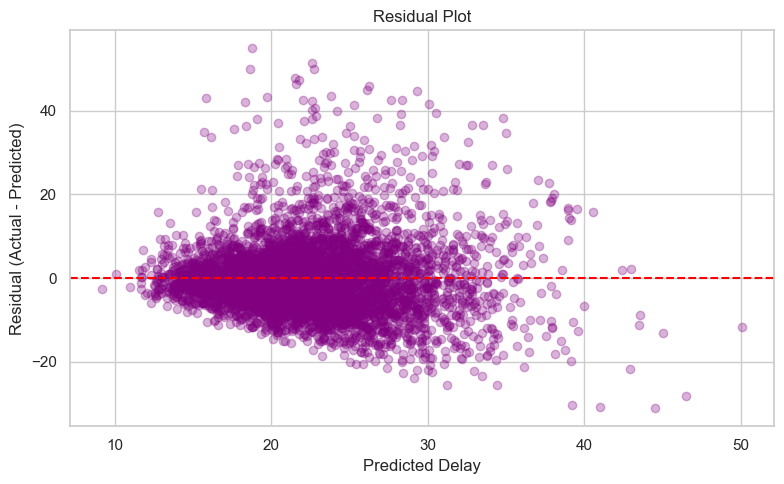

In [51]:

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  #
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.title("Actual vs Predicted Delays (Delayed Flights Only)")
plt.grid(True)
plt.tight_layout()
plt.show()
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Delay")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Feature Importance (by weight):
airport: 2468.0
month: 912.0
carrier: 877.0
time_idx: 400.0
delay_rate_lag1: 349.0
delay_rate_rolling3: 270.0
arr_del15_rolling3: 236.0
delay_rate_lag12: 231.0
delay_rate_lag3: 187.0
controllable_delay_lag1: 177.0
uncontrollable_delay_rolling3: 173.0
arr_delay_lag1: 171.0
controllable_delay_rolling3: 167.0
arr_del15_lag1: 162.0
uncontrollable_delay_lag1: 156.0
uncontrollable_delay_lag3: 153.0
uncontrollable_delay_lag12: 153.0
arr_delay_rolling3: 149.0
controllable_delay_lag12: 145.0
controllable_delay_lag3: 130.0
arr_del15_lag12: 109.0
arr_del15_lag3: 97.0
arr_delay_lag3: 97.0
arr_delay_lag12: 83.0
airport_avg_delay: 77.0
cos_month: 74.0
sin_month: 33.0
quarter: 22.0


<Figure size 700x500 with 0 Axes>

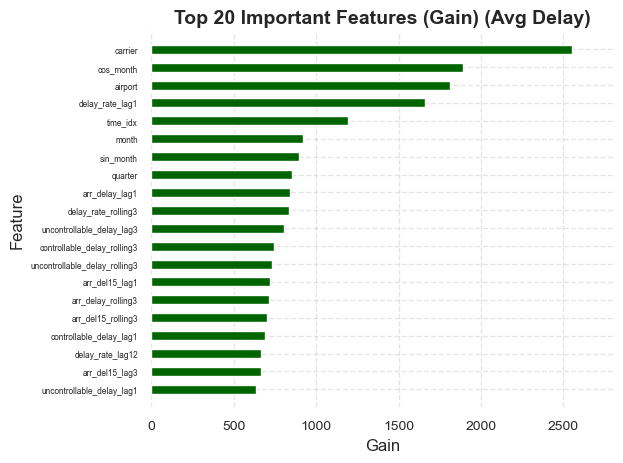

In [52]:
importance = reg.get_score(importance_type='weight')
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
print("🔍 Feature Importance (by weight):")
for feature, score in sorted_importance.items():
    print(f"{feature}: {score}")

plt.figure(figsize=(7, 5))
sns.set(style='whitegrid')

ax = xgb.plot_importance(
    reg,
    importance_type='gain',
    max_num_features=20,
    height=0.5,
    color='#006400',     
    grid=False,
    show_values=False,
    title=None,
)

plt.title("Top 20 Important Features (Gain) (Avg Delay)", fontsize=14, fontweight='bold')
plt.xlabel('Gain', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=6)
plt.box(False)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [53]:
mask = (y == 1)
X_filtered = X2[mask]
y_filtered = contr_delay_per_flight[mask]
w_filtered = sample_weight[mask]

pct = 99
threshold = np.percentile(y_filtered, pct)
print(f"Trimming delays > {pct}th percentile = {threshold:.1f} minutes")
keep = (y_filtered <= threshold)
X_trim = X_filtered[keep]
y_trim = y_filtered[keep]
w_trim = w_filtered[keep]

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_trim, y_trim, w_trim,
    test_size=0.2,
    random_state=42
)

dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest  = xgb.DMatrix(X_test,  label=y_test, enable_categorical=True)

params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse",
    "seed": 42
}

reg = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=[(dtest, "eval")],
    early_stopping_rounds=30,
    verbose_eval=10
)

y_pred = reg.predict(dtest)

print("\n📈 Regression Evaluation (trimmed at 99th percentile):")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mean_squared_error(y_test, y_pred):.4f}")
print(f"RMSE : {root_mean_squared_error(y_test, y_pred):.4f}")

Trimming delays > 99th percentile = 63.0 minutes
[0]	eval-rmse:8.58459
[10]	eval-rmse:8.10671
[20]	eval-rmse:7.85138
[30]	eval-rmse:7.71734
[40]	eval-rmse:7.63259
[50]	eval-rmse:7.59422
[60]	eval-rmse:7.58474
[70]	eval-rmse:7.55467
[80]	eval-rmse:7.56057
[90]	eval-rmse:7.54998
[100]	eval-rmse:7.54651
[110]	eval-rmse:7.54576
[120]	eval-rmse:7.54243
[130]	eval-rmse:7.54900
[140]	eval-rmse:7.55136
[150]	eval-rmse:7.55171
[156]	eval-rmse:7.55382

📈 Regression Evaluation (trimmed at 99th percentile):
MAE  : 5.3218
MSE  : 57.0603
RMSE : 7.5538


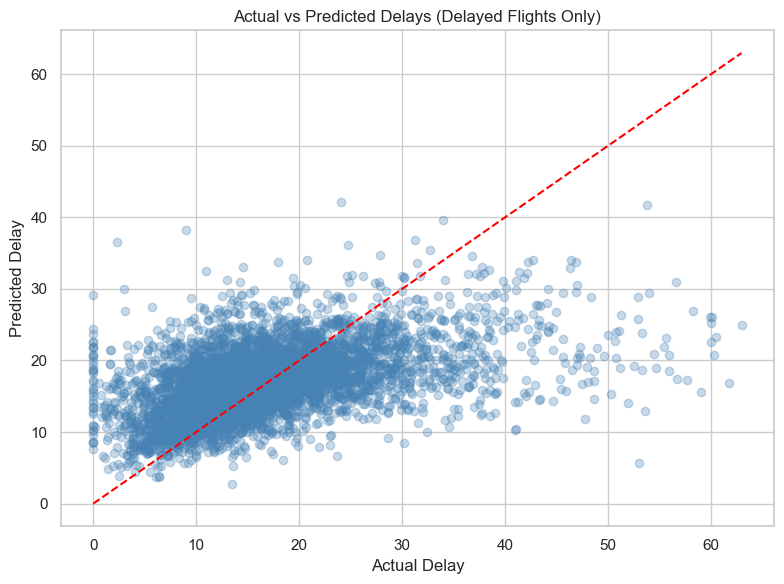

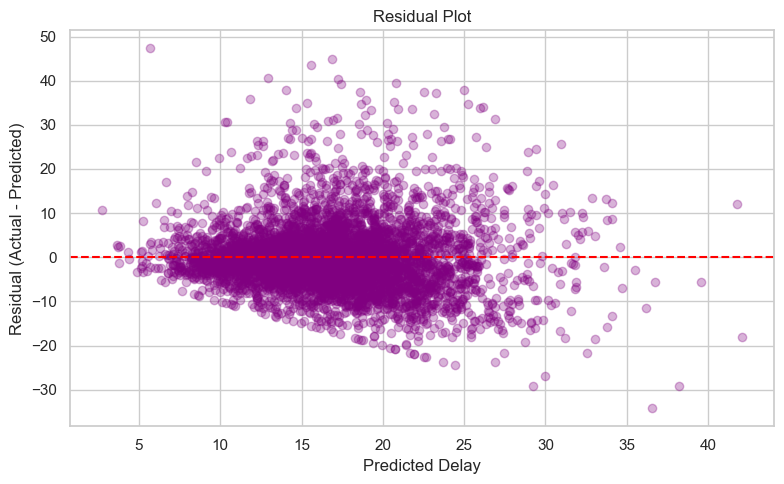

In [54]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='steelblue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # ideal line
plt.xlabel("Actual Delay")
plt.ylabel("Predicted Delay")
plt.title("Actual vs Predicted Delays (Delayed Flights Only)")
plt.grid(True)
plt.tight_layout()
plt.show()
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.3, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Delay")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()


🔍 Feature Importance (by weight):
airport: 2849.0
carrier: 1073.0
month: 980.0
time_idx: 425.0
delay_rate_lag1: 348.0
delay_rate_rolling3: 326.0
controllable_delay_lag1: 299.0
delay_rate_lag12: 271.0
controllable_delay_rolling3: 243.0
uncontrollable_delay_lag1: 243.0
arr_del15_rolling3: 239.0
uncontrollable_delay_rolling3: 223.0
delay_rate_lag3: 215.0
arr_delay_lag1: 169.0
arr_del15_lag1: 160.0
controllable_delay_lag3: 160.0
uncontrollable_delay_lag12: 154.0
controllable_delay_lag12: 153.0
uncontrollable_delay_lag3: 143.0
arr_delay_rolling3: 128.0
arr_delay_lag12: 110.0
arr_del15_lag3: 108.0
arr_del15_lag12: 95.0
arr_delay_lag3: 91.0
airport_avg_delay: 75.0
cos_month: 71.0
sin_month: 23.0
quarter: 16.0


<Figure size 700x500 with 0 Axes>

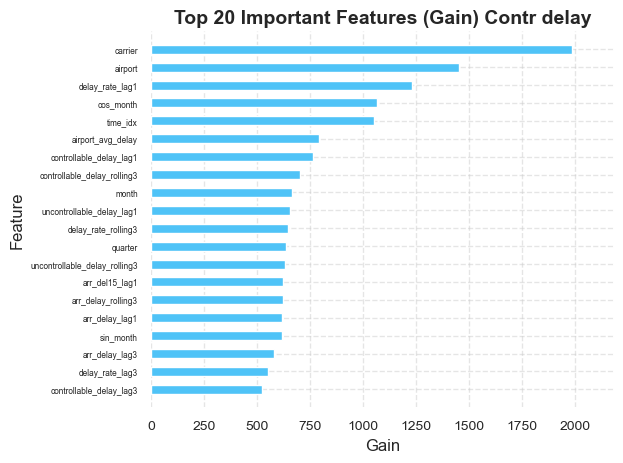

In [55]:
importance = reg.get_score(importance_type='weight')
sorted_importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))
print("🔍 Feature Importance (by weight):")
for feature, score in sorted_importance.items():
    print(f"{feature}: {score}")

plt.figure(figsize=(7, 5))
sns.set(style='whitegrid')

ax = xgb.plot_importance(
    reg,
    importance_type='gain',
    max_num_features=20,
    height=0.5,
    color='#4fc3f7',       
    grid=False,
    show_values=False,
    title=None,
)

plt.title("Top 20 Important Features (Gain) Contr delay", fontsize=14, fontweight='bold')
plt.xlabel('Gain', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=6)
plt.box(False)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
